## 데이터셋 1차 분석

### Imports

In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import torch
from datasets import load_from_disk

np.random.seed(42)
torch.manual_seed(42)

### Dataset Load

In [2]:
dataset = load_from_disk("./datasets/recyclables_image_classification")
train_ds = dataset["train"]
val_ds = dataset["validation"]

Loading dataset from disk:   0%|          | 0/60 [00:00<?, ?it/s]

### Dataset Class Distribution Visualization

In [3]:
class_names_train: pd.DataFrame = train_ds.select_columns("class_name").to_pandas()
class_names_val: pd.DataFrame = val_ds.select_columns("class_name").to_pandas()

In [4]:
train_class_dist = class_names_train.value_counts().reset_index()
px.bar(train_class_dist, x="class_name", y="count", title="Train Set Class Distribution", height=512, width=1024)

In [5]:
val_class_dist = class_names_val.value_counts().reset_index()
px.bar(val_class_dist, x="class_name", y="count", title="Validation Set Class Distribution", height=512, width=1024)

### Dataset Class Distribution Visualization (Truncated Labels)

In [6]:
class_names_train_truncated = class_names_train.copy(deep=True)
class_names_val_truncated = class_names_val.copy(deep=True)

class_names_train_truncated['class_name'] = class_names_train_truncated['class_name'].apply(lambda x: '_'.join(x.split('_')[:-1]))
class_names_val_truncated['class_name'] = class_names_val_truncated['class_name'].apply(lambda x: '_'.join(x.split('_')[:-1]))

In [7]:
train_class_dist = class_names_train_truncated.value_counts().reset_index()
px.bar(train_class_dist, x="class_name", y="count", title="Train Set Class Distribution with truncated labels", height=512, width=1024)

In [8]:
val_class_dist = class_names_val_truncated.value_counts().reset_index()
px.bar(val_class_dist, x="class_name", y="count", title="Validation Set Class Distribution with truncated labels", height=512, width=1024)

## 데이터셋 2차 분석

### Imports

In [9]:
from PIL import Image
from aie_project.training.dataset_utils import easy_load

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

### Dataset Load

In [10]:
dataset_2, material_label2id, material_id2label, transparency_label2id, transparency_id2label = \
    easy_load("./datasets/recyclables_image_classification", include_all_columns=True)
train_ds_2 = dataset_2["train"]
val_ds_2 = dataset_2["validation"]

Loading dataset from disk:   0%|          | 0/42 [00:00<?, ?it/s]

### Dataset Class Distribution Visualization

In [11]:
class_names_mat_train_2: pd.DataFrame = train_ds_2.select_columns("material_class_name").to_pandas()
class_names_mat_val_2: pd.DataFrame = val_ds_2.select_columns("material_class_name").to_pandas()

class_names_trans_train_2: pd.DataFrame = train_ds_2.select_columns("transparency_class_name").to_pandas()
class_names_trans_val_2: pd.DataFrame = val_ds_2.select_columns("transparency_class_name").to_pandas()

In [12]:
train_class_dist_mat_2 = class_names_mat_train_2.value_counts().reset_index()
px.bar(train_class_dist_mat_2, x="material_class_name", y="count", title="Train Set Material Class Distribution", height=384, width=1024)

In [13]:
val_class_dist_mat_2 = class_names_mat_val_2.value_counts().reset_index()
px.bar(val_class_dist_mat_2, x="material_class_name", y="count", title="Validation Set Material Class Distribution", height=384, width=1024)

In [14]:
train_class_dist_trans_2 = class_names_trans_train_2.value_counts().reset_index()
px.bar(train_class_dist_trans_2, x="transparency_class_name", y="count", title="Train Set Transparency Class Distribution", height=512, width=512)

In [15]:
val_class_dist_trans_2 = class_names_trans_val_2.value_counts().reset_index()
px.bar(val_class_dist_trans_2, x="transparency_class_name", y="count", title="Validation Set Transparency Class Distribution", height=512, width=512)

### Sample Image Visualization

In [16]:
def unnormalize_pixel_values(pixel_values: np.ndarray) -> Image.Image:
    unnormalized = pixel_values.copy()
    for i in range(3):  # Assuming 3 channels (RGB)
        unnormalized[i] = (unnormalized[i] * IMAGENET_STD[i]) + IMAGENET_MEAN[i]
    unnormalized = np.clip(unnormalized * 255, 0, 255).astype(np.uint8)
    unnormalized = np.transpose(unnormalized, (1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
    return Image.fromarray(unnormalized)

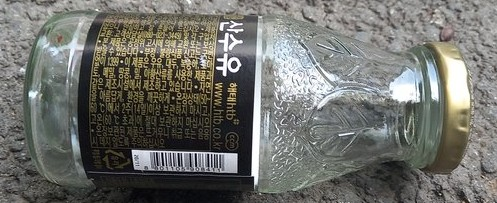

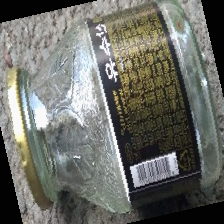

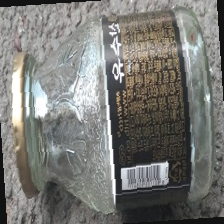

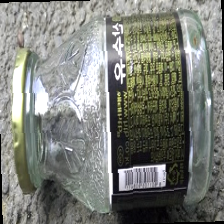

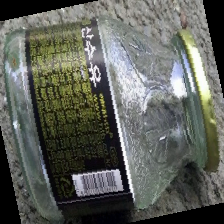

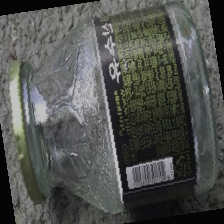

In [17]:
display(train_ds_2[0]['image'])
for i in range(5):
    display(unnormalize_pixel_values(train_ds_2[0]['pixel_values'].numpy()))

## 하이퍼파라미터 튜닝 기록 분석

### Imports

In [18]:
from aie_project.training.tune import get_study

### Get Study DataFrame

In [19]:
study = get_study()

tmp_df = study.trials_dataframe()
tmp_df.to_csv("trial_logs.csv", index=False)
study_df: pd.DataFrame = tmp_df.drop(columns=[
    col for col in study.trials_dataframe().columns if col.startswith("system_attrs_") or col.startswith("user_attrs_")
])

/Users/riverfog7/Workspace/ai_experiment_project/src/aie_project/training/tune.py:129: ExperimentalWarning:

RetryFailedTrialCallback is experimental (supported from v2.8.0). The interface can change in the future.

/Users/riverfog7/Workspace/ai_experiment_project/.venv/lib/python3.12/site-packages/optuna/_experimental.py:32: ExperimentalWarning:

Argument ``heartbeat_interval`` is an experimental feature. The interface can change in the future.

/Users/riverfog7/Workspace/ai_experiment_project/.venv/lib/python3.12/site-packages/optuna/_experimental.py:32: ExperimentalWarning:

Argument ``multivariate`` is an experimental feature. The interface can change in the future.

/Users/riverfog7/Workspace/ai_experiment_project/.venv/lib/python3.12/site-packages/optuna/_experimental.py:32: ExperimentalWarning:

Argument ``constant_liar`` is an experimental feature. The interface can change in the future.

[I 2025-12-11 22:01:08,739] Using an existing study with name 'ai-experiment-project-defau

In [20]:
study_df['duration'].sum().total_seconds() / 3600, len(study_df)

(173.38657094222222, 538)

### Plot Visualizations

In [21]:
# plot a violin plot of optimizer vs value
fig = px.violin(
    study_df[study_df['state'] != "FAIL"],
    x="params_optim",
    y="value",
    color="state",
    box=True,
    points="all",
    title="Optimizer vs Objective Value",
    width=1024,
    height=512
)
fig.show()

In [22]:
study_df_adamw = study_df[study_df["params_optim"] == "adamw_torch"]
study_df_adamw = study_df_adamw[study_df_adamw['state'] != "FAIL"]

In [23]:
px.violin(
    study_df_adamw,
    x="params_per_device_train_batch_size",
    y="value",
    color="state",
    box=True,
    points="all",
    title="Num Train Epochs vs Objective Value for AdamW Optimizer",
    width=1024,
    height=512
)

In [24]:
px.violin(
    study_df_adamw,
    x="params_num_train_epochs",
    y="value",
    color="state",
    box=True,
    points="all",
    title="Num Train Epochs vs Objective Value for AdamW Optimizer",
    width=1024,
    height=512
)

In [25]:
px.violin(
    study_df_adamw,
    x="state",
    y="value",
    color="state",
    box=True,
    points="all",
    title="Trial Run State vs Objective Value for AdamW Optimizer",
    width=1024,
    height=512
)

In [26]:
px.scatter(
    study_df_adamw,
    x="params_learning_rate",
    y="value",
    color="state",
    trendline="lowess",
    title="Learning Rate vs Objective Value for AdamW Optimizer With Trendline (lowess mode)",
    width=1024,
    height=512
)

In [27]:
px.scatter(
    study_df_adamw,
    x="params_weight_decay",
    y="value",
    color="state",
    trendline="lowess",
    title="Weight Decay vs Objective Value for AdamW Optimizer With Trendline (lowess mode)",
    width=1024,
    height=512
)

## 모델 테스트

### Imports & Model Load

In [28]:
from tempfile import mkdtemp
import shutil
from pathlib import Path
import torch
import torchview
from typing import List, Tuple
from tqdm import tqdm
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.manifold import TSNE
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

from aie_project.training.models import EfficientMultiTaskClassificationModel

MODEL_PATH = Path("./models/final_model").absolute()
if not MODEL_PATH.exists():
    raise FileNotFoundError(f"Model path {MODEL_PATH} does not exist.")

In [29]:
model = EfficientMultiTaskClassificationModel.from_pretrained(MODEL_PATH.as_posix())
_ = model.eval()

### Sample Model Inference

In [30]:
def draw_graph(images: List[Image.Image], preds: List[Tuple[str, str]], gts: List[Tuple[str, str]]) -> None:
    n = len(images)
    plt.figure(figsize=(4 * n, 6))

    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        ax.imshow(np.array(images[i]))

        p_mat, p_trans = preds[i]
        g_mat, g_trans = gts[i]

        c_mat = "green" if p_mat == g_mat else "red"
        c_trans = "green" if p_trans == g_trans else "red"

        for j, (text, color) in enumerate(zip(
            [f"Material: {p_mat} (GT: {g_mat})", f"Transparency: {p_trans} (GT: {g_trans})"],
            [c_mat, c_trans]
        )):
            ax.text(0.5, -0.1 - j * 0.2, text, color=color, fontsize=14, ha='center', va='top', transform=ax.transAxes)
        ax.axis("off")
    plt.tight_layout()
    plt.show()

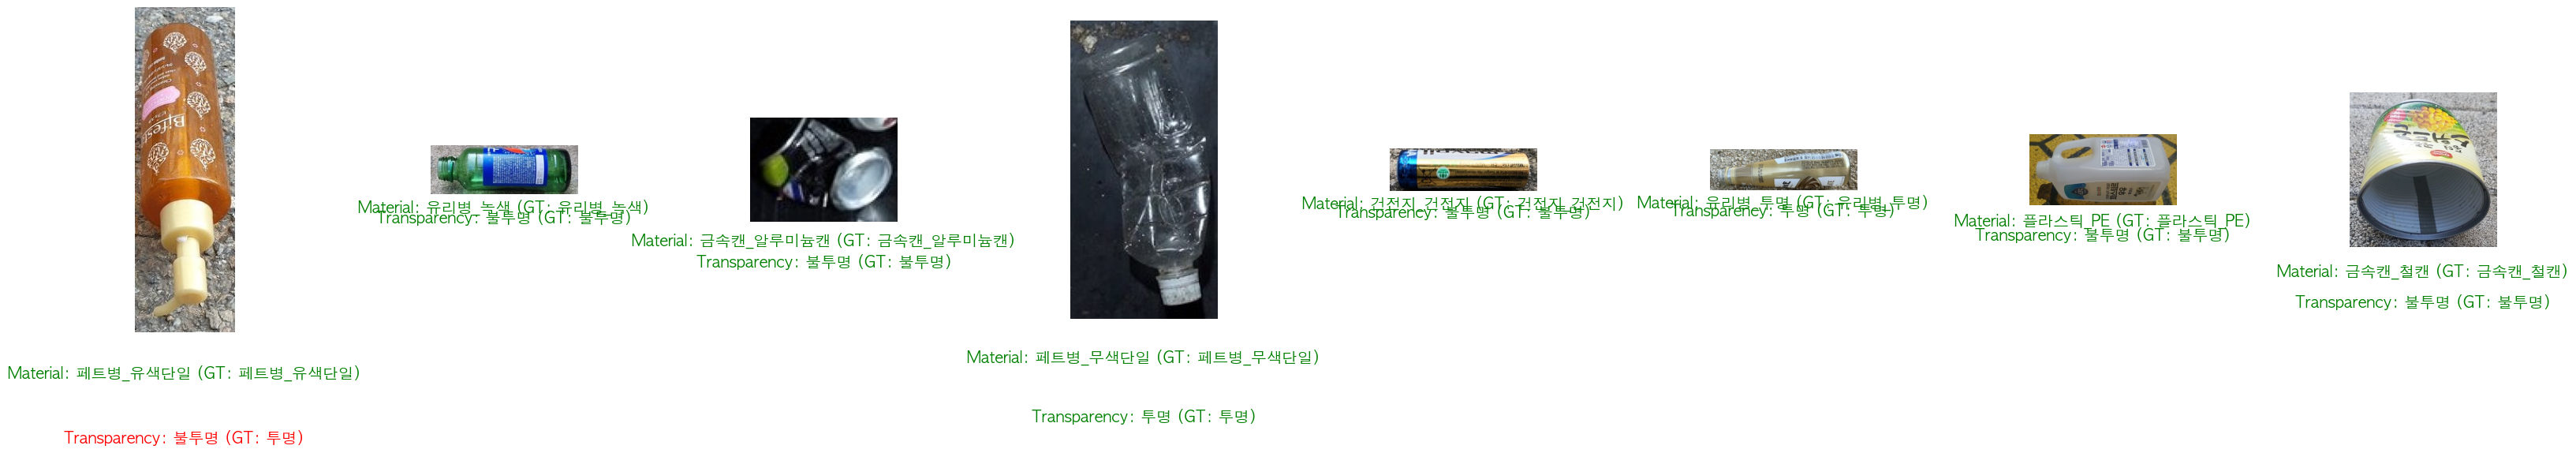

In [31]:
rand_idx = np.random.randint(0, len(val_ds), size=8)
input_data = val_ds_2[rand_idx]

with torch.no_grad():
    preds = model(
        pixel_values=torch.stack(input_data['pixel_values']),
        return_dict=True,
    )
preds_mat = [material_id2label[int(val)] for val in torch.softmax(preds.logits_1, dim=-1).argmax(dim=-1)]
preds_trans = [transparency_id2label[int(val)] for val in torch.softmax(preds.logits_2, dim=-1).argmax(dim=-1)]

draw_graph(
    images=input_data['image'],
    preds=list(zip(preds_mat, preds_trans)),
    gts=list(zip(input_data['material_class_name'], input_data['transparency_class_name'])),
)

### Draw Model Graph & Inspect Layers

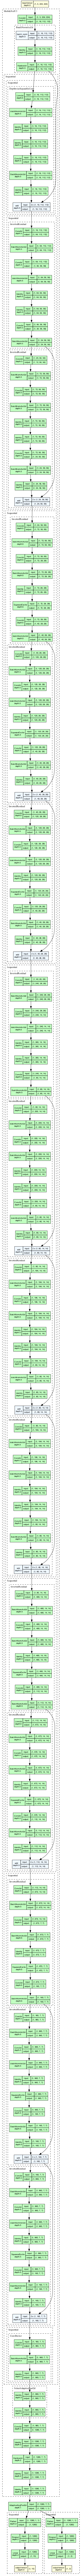

In [32]:
tmpdir = Path(mkdtemp())
with torch.no_grad():
    torchview.draw_graph(model, input_size=(1, 3, 224, 224), expand_nested=True, depth=5).visual_graph.render(
        filename=tmpdir / "model_graph",
        format="png",
        cleanup=False,
    )
display(Image.open(tmpdir / "model_graph.png"))
shutil.rmtree(tmpdir)

In [33]:
for i, block in enumerate(model.backbone.blocks):
    print(f"======== Block {i}: {len(block)} layers ========")
    for layer in block:
        print(layer.__class__.__name__, end="")
        if layer.__class__.__name__ == "InvertedResidual":
            if layer.se.__class__.__name__ != "Identity":
                print(f" with {layer.se.__class__.__name__},", end="")
            print(f" with ", end="")
            print(f"{layer.conv_pw.in_channels} -> ", end="")
            print(f"{layer.conv_dw.in_channels} -> ", end="")
            print(f"{layer.conv_pwl.in_channels} -> ", end="")
            print(f"{layer.conv_pwl.out_channels} channels")
        else:
            print()

======== Block 0: 1 layers ========
DepthwiseSeparableConv
======== Block 1: 2 layers ========
InvertedResidual with 16 -> 64 -> 64 -> 24 channels
InvertedResidual with 24 -> 72 -> 72 -> 24 channels
======== Block 2: 3 layers ========
InvertedResidual with SqueezeExcite, with 24 -> 72 -> 72 -> 40 channels
InvertedResidual with SqueezeExcite, with 40 -> 120 -> 120 -> 40 channels
InvertedResidual with SqueezeExcite, with 40 -> 120 -> 120 -> 40 channels
======== Block 3: 4 layers ========
InvertedResidual with 40 -> 240 -> 240 -> 80 channels
InvertedResidual with 80 -> 200 -> 200 -> 80 channels
InvertedResidual with 80 -> 184 -> 184 -> 80 channels
InvertedResidual with 80 -> 184 -> 184 -> 80 channels
======== Block 4: 2 layers ========
InvertedResidual with SqueezeExcite, with 80 -> 480 -> 480 -> 112 channels
InvertedResidual with SqueezeExcite, with 112 -> 672 -> 672 -> 112 channels
======== Block 5: 3 layers ========
InvertedResidual with SqueezeExcite, with 112 -> 672 -> 672 -> 160 cha

### Sample Inference & Layer Output Inspection

In [34]:
features = {}
def get_feature_hook(name):
    def hook(model, input, output):
        print(f"--- Inside layer: {name} ---")
        print(f"Output shape: {output.shape}")
        features[name] = output.detach().cpu().numpy()
    return hook

for i, block in enumerate(model.backbone.blocks):
    block.register_forward_hook(get_feature_hook(f"block_{i}"))

In [35]:
test_data = val_ds_2[-42823]
with torch.no_grad():
    _ = model(
        pixel_values=test_data['pixel_values'].unsqueeze(0),
        return_dict=True,
    )

for i, block in enumerate(model.backbone.blocks):
    block._forward_hooks.clear()

--- Inside layer: block_0 ---
Output shape: torch.Size([1, 16, 112, 112])
--- Inside layer: block_1 ---
Output shape: torch.Size([1, 24, 56, 56])
--- Inside layer: block_2 ---
Output shape: torch.Size([1, 40, 28, 28])
--- Inside layer: block_3 ---
Output shape: torch.Size([1, 80, 14, 14])
--- Inside layer: block_4 ---
Output shape: torch.Size([1, 112, 14, 14])
--- Inside layer: block_5 ---
Output shape: torch.Size([1, 160, 7, 7])
--- Inside layer: block_6 ---
Output shape: torch.Size([1, 960, 7, 7])


In [36]:
def plot_feature_maps(feature_maps, num_maps=4):
    if isinstance(feature_maps, torch.Tensor):
        feature_maps = feature_maps.detach().cpu().numpy()

    if feature_maps.ndim == 4:
        feature_maps = feature_maps.squeeze(0)  # (C, H, W)

    channel_energy = np.sum(np.abs(feature_maps), axis=(1, 2))
    sorted_indices = np.argsort(channel_energy)[::-1]
    active_indices = sorted_indices[:num_maps]

    cols = 4
    rows = (num_maps + cols - 1) // cols

    plt.figure(figsize=(cols * 3, rows * 3))

    for i, ch_idx in enumerate(active_indices):
        ax = plt.subplot(rows, cols, i + 1)

        map_data = feature_maps[ch_idx]

        ax.imshow(map_data, cmap='viridis')
        ax.set_title(f"Ch {ch_idx} (Energy: {channel_energy[ch_idx]:.1f})")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

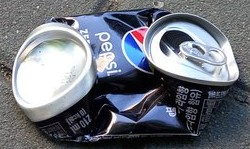

In [37]:
test_data['image']

Feature maps from layer: block_0


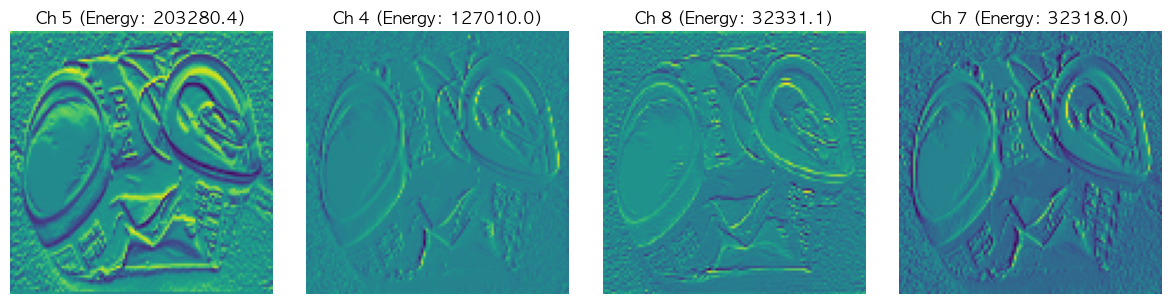

Feature maps from layer: block_1


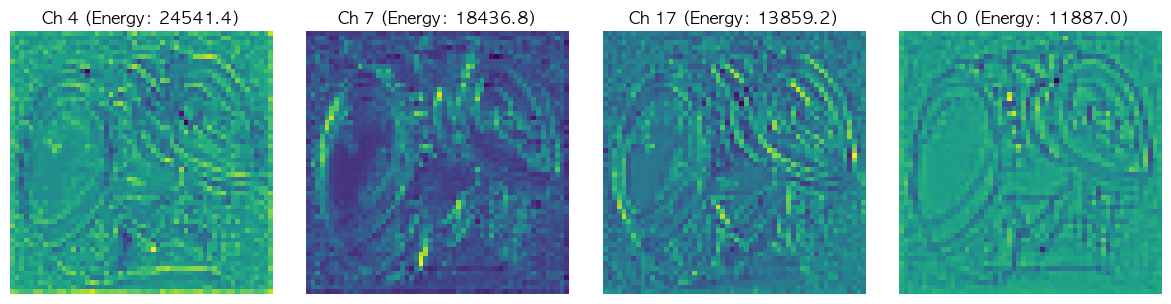

Feature maps from layer: block_2


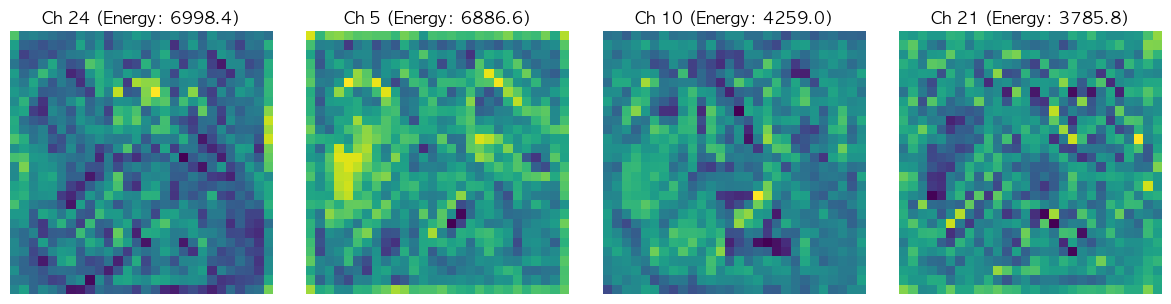

Feature maps from layer: block_3


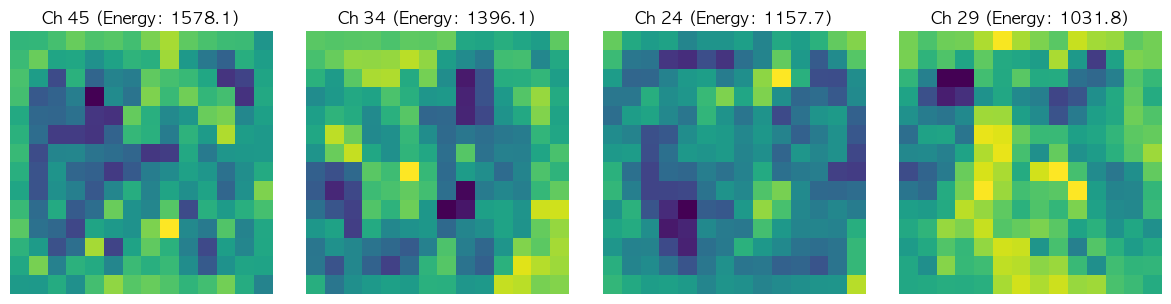

Feature maps from layer: block_4


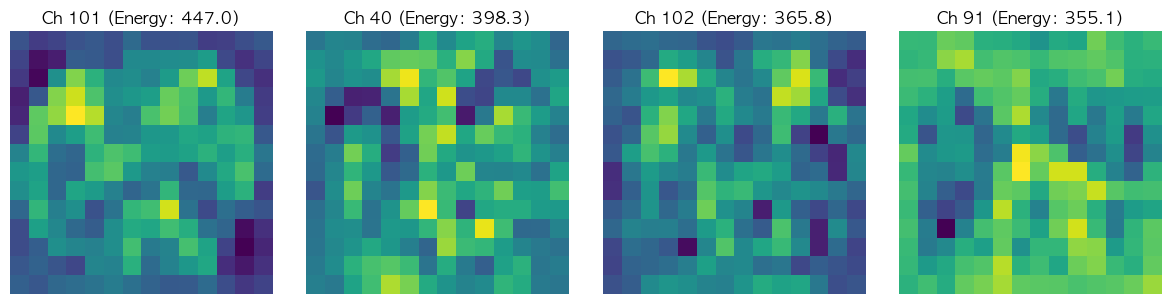

Feature maps from layer: block_5


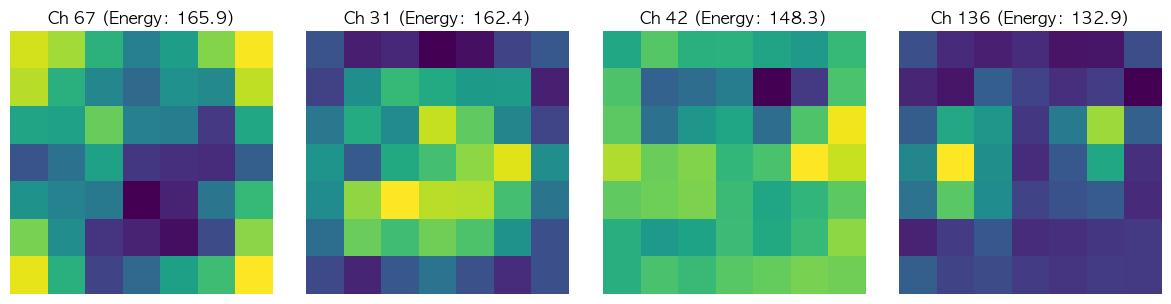

Feature maps from layer: block_6


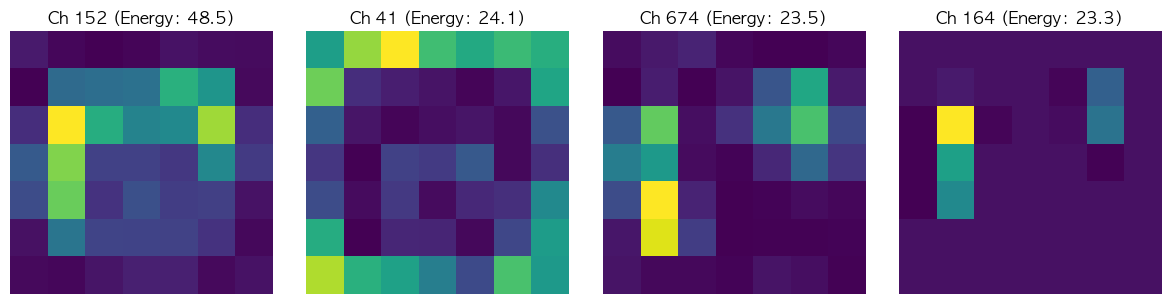

In [38]:
for layer_name, feature_map in features.items():
    print(f"Feature maps from layer: {layer_name}")
    plot_feature_maps(feature_map, num_maps=4)

### t-SNE Visualization of Feature Embeddings

In [39]:
batch_size = 1024
device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"

embeddings = []
print_done = False
model.backbone.to(device)
for i in tqdm(range(0, len(val_ds_2), batch_size)):
    batch_data = val_ds_2[i:i+batch_size]
    with torch.no_grad():
        outputs = model.backbone(
            torch.stack(batch_data['pixel_values']).to(device)
        )
        outputs = model.pool(outputs)
        if not print_done:
            print(f"Model feature embedding shape: {outputs[0].shape}")
            print_done = True
    batch_embeddings = outputs[:, :, 0, 0].cpu().numpy()
    embeddings.extend(list(batch_embeddings))
embeddings = np.array(embeddings)
print(f"Total embeddings shape: {embeddings.shape}")

  0%|          | 0/126 [00:00<?, ?it/s]

Model feature embedding shape: torch.Size([1280, 1, 1])


100%|██████████| 126/126 [03:38<00:00,  1.73s/it]


Total embeddings shape: (128500, 1280)


In [40]:
tsne = TSNE(n_components=3, random_state=42)
embeddings_3d = tsne.fit_transform(embeddings)

print(f"Dimension reduced embeddings shape: {embeddings_3d.shape}")

Dimension reduced embeddings shape: (128500, 3)


In [41]:
fig = px.scatter_3d(
    x=embeddings_3d[:, 0],
    y=embeddings_3d[:, 1],
    z=embeddings_3d[:, 2],
    color=val_ds_2.select_columns("material_class_name").to_pandas()["material_class_name"],
    title="3D t-SNE Visualization of Image Feature Embeddings (Material)",
    width=720,
    height=512,
    opacity=0.5,
)
fig.update_traces(marker_size=1)
with open("./tsne_embeddings_3d_mat.html", "w", encoding='utf-8') as f:
    f.write(fig.to_html(full_html=False, include_plotlyjs='cdn'))
fig.show()

In [43]:
fig = px.scatter_3d(
    x=embeddings_3d[:, 0],
    y=embeddings_3d[:, 1],
    z=embeddings_3d[:, 2],
    color=val_ds_2.select_columns("transparency_class_name").to_pandas()["transparency_class_name"],
    title="3D t-SNE Visualization of Image Feature Embeddings (Transparency)",
    width=720,
    height=512,
    opacity=0.5,
)
fig.update_traces(marker_size=1)
with open("./tsne_embeddings_3d_trans.html", "w", encoding='utf-8') as f:
    f.write(fig.to_html(full_html=False, include_plotlyjs='cdn'))
fig.show()